In [1]:
# fetch MNIST dataset:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

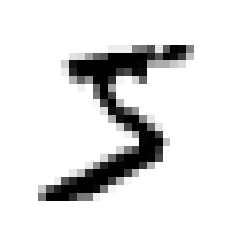

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

X = X.to_numpy()
some_digit = X[0]
# reshape the features into a 28x28 pixels matrix(image)
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[0]

'5'

In [7]:
import numpy as np
y = y.astype(np.uint8)

In [8]:
type(y[0])

numpy.uint8

In [9]:
def plot_digit(data):
    # data = data.to_numpy()
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary,
              interpolation='nearest')
    plt.axis('off')

In [10]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

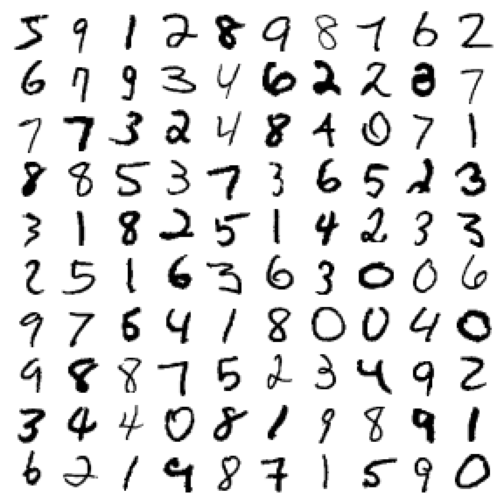

In [11]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<h1>Binary Classifier</h1>

In [13]:
y_train_5 = (y_train == 5) # True for all 5s, False for everything else
y_test_5 = (y_test == 5)

In [14]:
# Stochastic Gradient Descent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([X[2]])

array([False])

In [16]:
sgd_clf.predict([some_digit])

array([ True])

<h2>Performance Measures

<h3>Measuring Accuracy Using Cross-Validation

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) # SGDClassifier(random_state=42) fit
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.8642
0.87215
0.88795


In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [19]:
# a dumb classifier that classifies every image as "not-5"
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

<h3>Confusion Matrix

In [21]:
# cross_val_predict returns prediction made on each test fold<h3
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [23]:
# A perfect classifier:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

<h3>Precision and Recall

In [24]:
from sklearn.metrics import precision_score, recall_score

In [25]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [27]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

<h3>Precision/Recall Trade-off

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [32]:
y_scores.size

60000

In [33]:
# func to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

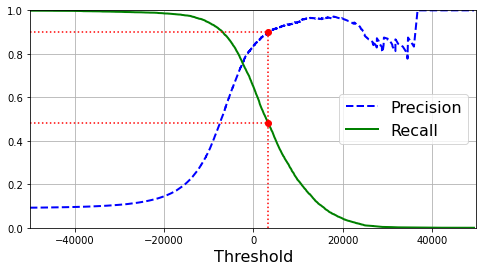

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

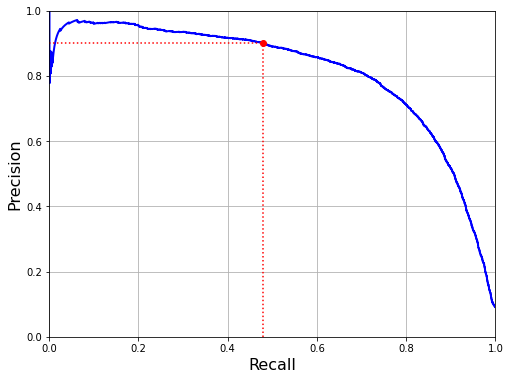

In [35]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [36]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [37]:
threshold_90_precision

3370.0194991439557

In [38]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [39]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [40]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

<h3>The ROC Curve

In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

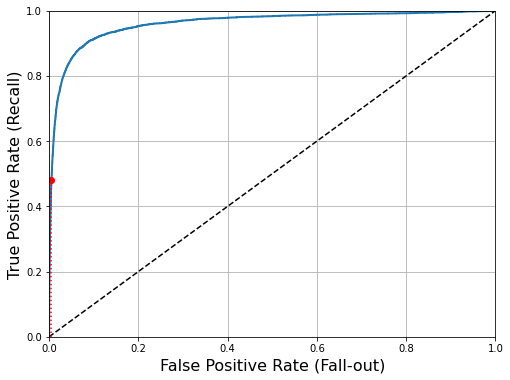

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)
    
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
# chosen ratio:
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")

plt.show()

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [45]:
y_probas_forest[:, 1]

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [46]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

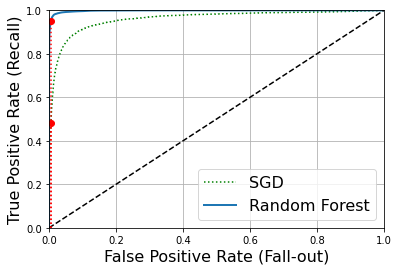

In [47]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.plot(fpr, tpr, "g:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

<h1>Multiclass Classification

In [49]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [50]:
# decision_function() returns 1 score per class
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
for index, score in enumerate(some_digit_scores[0]):
    print(index, ':', score)

0 : 1.7250197664732896
1 : 2.7280908822885768
2 : 7.2510017991420455
3 : 8.307637896172595
4 : -0.31087254321792546
5 : 9.313248199189204
6 : 1.7097510328947647
7 : 2.7676520238948132
8 : 6.230495365837555
9 : 4.84771047760298


In [51]:
np.argmax(some_digit_scores)

5

In [52]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [53]:
# forcing to use one determinated classifier with SVC
from sklearn.multiclass import OneVsRestClassifier


ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
len(ovr_clf.estimators_)

10

In [55]:
# training SGDClassifier 
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [56]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [57]:
# it takes a while...
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [58]:
# measuring the accuracy with scaled inputs 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

<h1>Error Analysis

In [59]:
# make predictions
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
# conf matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

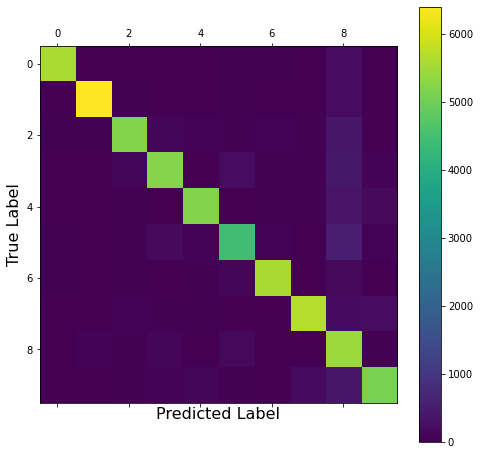

In [60]:
# plot a colorful matrix (i like fancy plots)
def plot_conf_mx(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
    plt.xlabel('Predicted Label', fontsize=16)
    plt.ylabel('True Label', fontsize=16)
    
    
plot_conf_mx(conf_mx)

In [61]:
# divide each value in the confusion matrix by number of images in the correspondig class
# compare error rates instead of absolute numbers of errors 

In [62]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

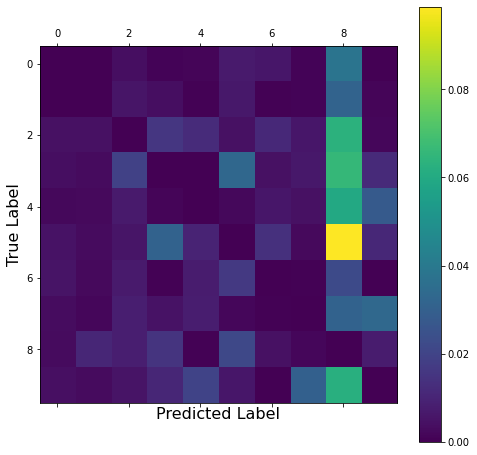

In [63]:
# fill the diagonal with 0s to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_conf_mx(norm_conf_mx)
plt.show()

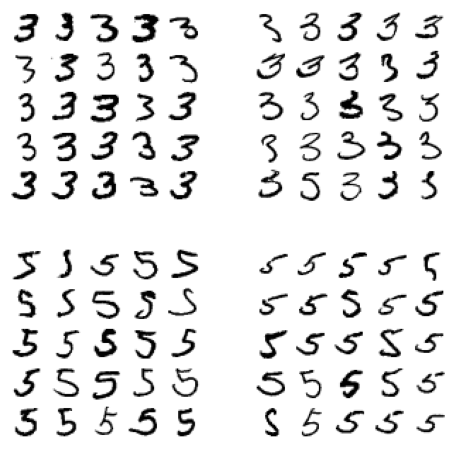

In [64]:
# plotting examples of 3s and 5s 
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # True Positive 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # False Positve 3
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # False Positive 5 
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # True Positive 5

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

<h1>Multilabel Classification

In [65]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [66]:
# index of dataset prediction image
some_index = 0

In [67]:
knn_clf.predict([X[some_index]])

array([[False,  True]])

In [68]:
print('Real Value:', y[some_index])
print("Prediction for '>=':", knn_clf.predict([X[some_index]])[0][0])
print("Prediction for 'odd':", knn_clf.predict([X[some_index]])[0][1])

Real Value: 5
Prediction for '>=': False
Prediction for 'odd': True


In [69]:
# evaluating the F1 (harmonic mean between precision and recall) score for each individual label, 
# then compute the average score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

<h1>Multioutput Classification

In [70]:
# creating training and test sets - MNIST images with noise added (np.randint())
noise = np.random.randint(0, 100, (len(X_train), 784)) # 784 = 28 * 28 pixels
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

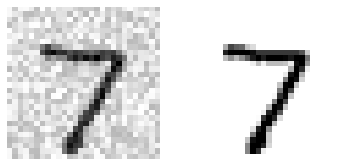

In [71]:
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

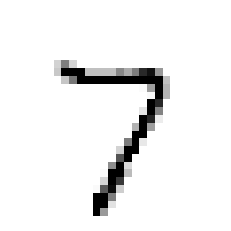

In [73]:
# training classifier ro make ir clean
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

<h1>Exercices

<h2>1.Build a classifier for MNIST dataset that achieves over 97% accuracy

In [74]:
# fine-tuning the model through GridSearchCV
from sklearn.model_selection import GridSearchCV


# declaring the hyperparam to be experimented
param_grid = [{'weights': ["uniform", "distance"], 
               'n_neighbors' : [3, 4, 5]}]

# using KNeighborsClassifier
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  15.7s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  15.7s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  15.4s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  15.6s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  15.3s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  15.1s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  14.9s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  15.2s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  15.9s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  15.9s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  18.6s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [75]:
# best params:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [76]:
# best score
grid_search.best_score_

0.9716166666666666

In [77]:
# measuring accuracy
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

<h2>2. Data Augmentation

In [78]:
# function to shift pixels
from scipy.ndimage.interpolation import shift

def shift_img(image, dx, dy):
    img = image.reshape((28,28))
    shifted_img = shift(img, [dy, dx], cval=0, mode="constant")
    return shifted_img.reshape([-1])

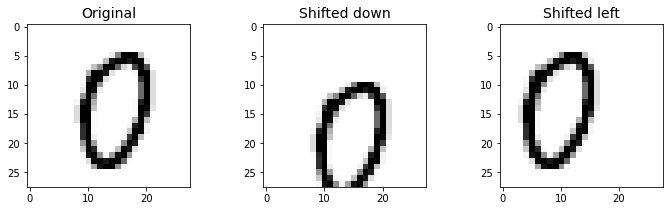

In [79]:
test_img = X_train[1000]
shifted_image_down = shift_img(test_img, 0, 5)
shifted_image_left = shift_img(test_img, -5, 0)

# plot the tests results
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(test_img.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [80]:
# creating augmented dataset
# appending original data
X_train_augmented = [image for image in X_train] # i realy enjoy python syntax
y_train_augmented = [label for label in y_train]

# appending augmented data
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_img(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [81]:
# shuffling the data set
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [82]:
# declaring estimator with best trained model and its best params
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [83]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [84]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

<h2>3.Tackle the Titanic dataset

In [2]:
# fetch the data and load it
import os
import urllib.request 

TITANIC_PATH = os.path.join('datasets', 'titanic')
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ('train.csv', 'test.csv'):
        filepath = os.path.join(path, filename)
        if not os.path.join(filename):
            print('Downloading', filename)
            urrlib.request.urlretrive(url + filename, filepath)

fetch_titanic_data()